# 1. Setup

## 1.1 Install Dependencies

In [ ]:
%pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
# Import standard libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [3]:
# Import TensorFlow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
import tensorflow as tf

## 1.3 Create Folder Strutures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Postives and Anchors

## 2.1 Retrieve Labelled Faces in the Wild Dataset

Installing another package - retrieves the required dataset from kaggle

In [14]:
%pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl (172 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kagglehub]
Note: you may need to restart the kernel to use updated packages.


Using Kaggles API to download the dataset locally to your computer.

You may need to create a Kaggle Account and create an API key.

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

/opt/anaconda3/envs/deepface/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 112M/112M [00:04<00:00, 24.7MB/s] 

Extracting files...


Path to dataset files: /Users/ethanvillalovoz/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


The downloaded dataset was stored in my .cache directory of my machine.

Moves it to the current working directory you are coding this project in.

In [16]:
import shutil
import os

# Source path (where KaggleHub downloaded the dataset)
src_path = "/Users/ethanvillalovoz/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4"

# Destination path (your project directory, e.g., 'data/lfw-dataset')
dst_path = os.path.join(os.getcwd(), "data", "lfw-dataset")

# Move the directory
if not os.path.exists(dst_path):
    shutil.move(src_path, dst_path)
    print(f"Dataset moved to: {dst_path}")
else:
    print("Destination already exists. Remove it first if you want to overwrite.")

Dataset moved to: /Users/ethanvillalovoz/Desktop/deepface-oneshot-paper-reimplementation/data/lfw-dataset


Moves all of the images from the dataset into our negative image folder

In [ ]:
for directory in os.listdir(dst_path):
    if directory.startswith("lfw-deepfunneled"):
        src_dir = os.path.join(dst_path, directory)
        for sub_directory in os.listdir(src_dir):
            if directory.startswith("lfw-deepfunneled"):
                sub_dir_path = os.path.join(src_dir, sub_directory)
                for filename in os.listdir(sub_dir_path):
                    filename_path = os.path.join(sub_dir_path, filename)
                    for image in os.listdir(filename_path):
                        if image.endswith(".jpg"):
                            image_path = os.path.join(filename_path, image)
                            print(f"Processing image: {image_path}")
                            final_dst_path = os.path.join(NEG_PATH, image)
                            print(f"dst_path: {final_dst_path}")
                            shutil.move(image_path, final_dst_path)
                            print(f"Moved {image_path} to {final_dst_path}")

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library for unique file names
import uuid

In [8]:
# Establish connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame = frame[120:120+250, 120:120+250, :]  # Crop the frame to a square

    # Collect anchor images
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create a unique filename using uuid
        imgname = os.path.join(ANC_PATH, f"{uuid.uuid1()}.jpg")
        # Wrute the image to the anchor path
        cv2.imwrite(imgname, frame)

    # Collect positive images
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create a unique filename using uuid
        imgname = os.path.join(POS_PATH, f"{uuid.uuid1()}.jpg")
        # Wrute the image to the anchor path
        cv2.imwrite(imgname, frame)

    # Display the frame
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [51]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

## 3.2 Preprocessing - Scale and Resize

In [52]:
def preprocess_image(image_path):

    # Read in image from path
    image = tf.io.read_file(image_path)

    # Load in the image
    image = tf.image.decode_jpeg(image)

    # Preprocessing steps
    # Resize the image to a fixed size 105x105x3
    image = tf.image.resize(image, [105, 105])
    image = (image / 255.0)  # Normalize to [0, 1]

    # Return the processed image
    return image

## 3.3 Create Labelled Dataset

In [53]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

In [54]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# Combine the datasets
dataset = positives.concatenate(negatives)

In [55]:
example = dataset.as_numpy_iterator().next()
print("Example from dataset:")
print("Anchor:", example[0])
print("Positive:", example[1])
print("Label:", example[2])

Example from dataset:
Anchor: b'data/anchor/e0c666de-3a55-11f0-bb5e-acde48001122.jpg'
Positive: b'data/positive/403420fc-3a56-11f0-bb5e-acde48001122.jpg'
Label: 1.0


## 3.4 Build Train and Test Partition

In [56]:
def preprocess_image_twin(input_img, value_img, label):
    input_img = preprocess_image(input_img)
    value_img = preprocess_image(value_img)
    return (input_img, value_img, label)

In [57]:
res = preprocess_image_twin(*example)

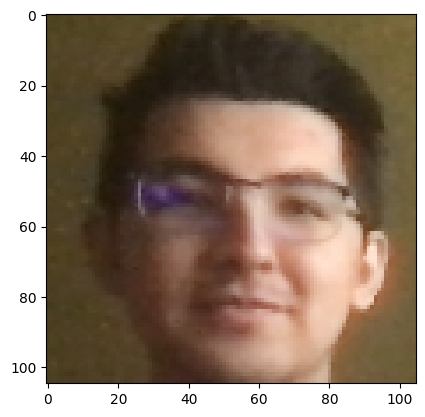

In [58]:
plt.imshow(res[1])

In [59]:
# Build dataLoader pipeline
data = dataset.map(preprocess_image_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [60]:
# Training partition
train_data = data.take(round(len(data) * 0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [61]:
# Testing partition
test_data = data.skip(round(len(data) * 0.8))
test_data = test_data.take(round(len(data) * 0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [89]:
def making_embedding_model():
    # Input layer
    input_img = Input(shape=(105, 105, 3), name='input_image')

    # Convolutional layers

    # First convolutional layer
    c1 = Conv2D(64, (10, 10), activation='relu')(input_img)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second convolutional layer
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third convolutional layer
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Fourth convolutional layer
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=input_img, outputs=d1, name='embedding_model')

In [91]:
embedding = making_embedding_model()
# Create the embedding model
embedding.summary()

Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [92]:
# Siamese L1 Distance class
class L1Distance(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, value_embedding):
        # Calculate the absolute difference
        return tf.math.abs(input_embedding - value_embedding)


## 4.3 Make Siamese Model

In [93]:
def make_siamese_network():
    
    # Anchor image input in the network
    input_image = Input(shape=(105, 105, 3), name='input_image')

    # Validation image input in the network
    validation_image = Input(shape=(105, 105, 3), name='validation_image')

    # Combine siamese distance components
    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classification = Dense(1, activation='sigmoid', name='classification')(distances)

    return Model(inputs=[input_image, validation_image], outputs=[classification], name='siamese_network')

In [95]:
siamese_model = make_siamese_network()
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance_7       │ (None, 4096)      │          0 │ embedding_model[… │
│ (L1Distance)        │                   │            │ embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │      4,097 │ l1_distance_7[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)